#Study of the latent space

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


In [ ]:
#initial parameters
t = np.arange(1, 101, 1)
n = 20000 #number of samples
number_train_data= int(n*0.9*0.7)
number_val_data= int(n*0.9*0.3)
number_test_data = int(n*0.1)

In [ ]:
#definition of empty matrices
period = [0 for _ in range(n)]
amplitud = [0 for _ in range(n)]
phase = [0 for _ in range(n)]
x = [[0 for _ in range(100)] for _ in range(n)] #n files 100 columnes
x = np.array(x).astype("float32")
train_data = np.empty(shape=(number_train_data, 100), dtype='object')
val_data = np.empty(shape=(number_val_data, 100), dtype='object')
test_data = np.empty(shape=(number_test_data, 100), dtype='object')
input_data=[]

In [ ]:
#creation of input data
for i in range(n):
  amplitud[i] = np.random.uniform(1, 10)
  period[i] = np.random.uniform(25,50)
  phase[i] = np.random.uniform(0, 360)

for i in range(n):
  for j in range(100):
    x[i,j] = amplitud[i] * np.sin(2. * np.pi * (t[j] / period[i] + phase[i] / 360.))

for i in range(number_train_data):
  for j in range(100):
    train_data[i][j]=x[i,j]

for i in range(number_train_data, number_train_data+number_val_data):
  for j in range(100):
    val_data[i-number_train_data][j]=x[i,j]

for i in range(number_train_data+number_val_data, n):
  for j in range(100):
    test_data[i-number_train_data-number_val_data][j]=x[i,j]

train_data = np.array(train_data).astype('float32')
val_data = np.array(val_data).astype('float32')
test_data = np.array(test_data).astype('float32')

train_data = train_data[~np.isnan(train_data)]
val_data = val_data[~np.isnan(val_data)]
test_data = test_data[~np.isnan(test_data)]

train_data = train_data.reshape((len(train_data)//100,100*1)).astype('float32')
val_data = val_data.reshape((len(val_data)//100,100*1)).astype('float32')
test_data = test_data.reshape((len(test_data)//100,100*1)).astype('float32')

input_data=np.concatenate((train_data,val_data,test_data), axis=None).astype('float32')

train_data = (train_data-np.min(input_data))/(np.max(input_data)-np.min(input_data))
val_data = (val_data-np.min(input_data))/(np.max(input_data)-np.min(input_data))
test_data = (test_data-np.min(input_data))/(np.max(input_data)-np.min(input_data))

train_data = train_data.reshape((-1, 1, 100))
test_data = test_data.reshape((-1, 1, 100))
val_data = val_data.reshape((-1, 1, 100))

train_data = tf.stack(train_data)
val_data= tf.stack(val_data)
test_data= tf.stack(test_data)

Latent space dimension


In [ ]:
latent_dims = np.arange(1,20, 1)
lossesvecval = []
for k in range(len(latent_dims)):
  class Autoencoder(Model):
      def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dims[k]
        self.encoder = tf.keras.Sequential([
          layers.Dense(100, activation='linear'),
          layers.Dense(100, activation='relu'),
          layers.Dense(80, activation='relu'),
          layers.Dense(latent_dims[k], activation='relu'),
          ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(80, activation='relu'),
            layers.Dense(100, activation='relu'),
            layers.Dense(100, activation='linear'),
          ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

  autoencoder = Autoencoder(latent_dim=latent_dims[k])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
  autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())
  history = autoencoder.fit(train_data, train_data,
                epochs=60,
                shuffle=True,
                batch_size=128,
                validation_data=(val_data, val_data), callbacks=[early_stopping])

  last_epoch_loss2 = history.history['val_loss'][-1]
  lossesvecval.append(last_epoch_loss2)


Text(0, 0.5, 'Val loss')

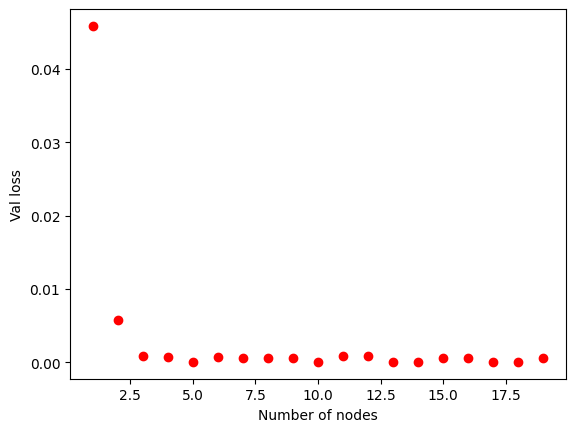

In [ ]:
plt.scatter(latent_dims, lossesvecval, color='red')
plt.xlabel('Number of nodes')
plt.ylabel('Val loss')

In [ ]:
lossesvecval

[0.045844968408346176,
 0.005749780219048262,
 0.0008989294292405248,
 0.0007516896002925932,
 7.442966307280585e-05,
 0.0007667025256597032,
 0.0006534150736325933,
 0.0005556880226425932,
 0.0006406403458325933,
 6.332472070500585e-05,
 0.0008574508158425932,
 0.0008822663657258932,
 5.6411525419695856e-05,
 6.333114172720585e-05,
 0.0006441942789773333,
 0.0005305962116385933,
 5.338264717404585e-05,
 6.349392743027586e-05,
 0.0005517063246391932]

Optimisation hyper-parameters

In [ ]:
latent_dim = 3
lossesvec = []
lossesvecval = []
hyper2 = np.arange(70,101,10)
hyper3 = np.arange(70,101,10)
activations = ['linear', 'sigmoid', 'relu']
for i in range(len(activations)):
  for j in range(len(hyper2)):
    for l in range(len(hyper3)):
      class Autoencoder(Model):
        def __init__(self, latent_dim):
          super(Autoencoder, self).__init__()
          self.latent_dim = latent_dim
          self.encoder = tf.keras.Sequential([
            layers.Dense(100, activation='linear'),
            layers.Dense(100, activation=activations[i]),
            layers.Dense(hyper2[j], activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
            ])
          self.decoder = tf.keras.Sequential([
            layers.Dense(hyper3[l], activation='relu'),
            layers.Dense(100, activation='sigmoid'),
            layers.Dense(100, activation='linear'),
            ])

        def call(self, x):
          encoded = self.encoder(x)
          decoded = self.decoder(encoded)
          return decoded

      autoencoder = Autoencoder(latent_dim)
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
      autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())
      history = autoencoder.fit(train_data, train_data,
                epochs=80,
                shuffle=True,
                batch_size=128,
                validation_data=(val_data, val_data), callbacks=[early_stopping])

      #autoencoder.summary() to see if our code was changing latent_dim properly
      last_epoch_loss1 = history.history['loss'][-1]
      lossesvec.append(last_epoch_loss1)
      last_epoch_loss2 = history.history['val_loss'][-1]
      lossesvecval.append(last_epoch_loss2)

In [ ]:
res = [np.argmax(lossesvecval), max(lossesvecval), np.argmin(lossesvecval), min(lossesvecval)]


Index 38 corresponds to the architecture:

      self.encoder = tf.keras.Sequential([
            layers.Dense(100, activation='linear'),   
            layers.Dense(100, activation='relu'),
            layers.Dense(80, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
            ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(80, activation='relu'),
            layers.Dense(100, activation='sigmoid'),
            layers.Dense(100, activation='linear'),
          ])

Visualisation of latent space


In [ ]:
from mpl_toolkits.mplot3d import Axes3D


Phase

In [ ]:
m = 1000

yp1 = np.array([[0 for _ in range(100)] for _ in range(m)]).astype("float32") #2000 files 100 columnes
period1 = [0 for _ in range(m)]
amplitud1 = [0 for _ in range(m)]
phase1p = [0 for _ in range(m)]
data_p1 = np.empty(shape=(m, 100), dtype='object')

In [ ]:
for i in range(m):
  amplitud1[i] = 10
  period1[i] = 25
  phase1p[i] = np.random.uniform(0, 360)

phase1p = sorted(phase1p)

for i in range(m):
  for j in range(100):
    yp1[i,j] = amplitud1[i] * np.sin(2. * np.pi * (t[j] / period1[i] + phase1p[i] / 360.))

for i in range(m):
  for j in range(100):
    data_p1[i][j]=yp1[i,j]

data_p1 = np.array(data_p1).astype('float32')
data_p1 = data_p1[~np.isnan(data_p1)]
data_p1 = data_p1.reshape((len(data_p1)//100,100*1)).astype('float32')

data_p1 = (data_p1-np.min(data_p1))/(np.max(data_p1)-np.min(data_p1))
data_p1 = data_p1.reshape((-1, 1, 100))
data_p1 = tf.stack(data_p1)



In [ ]:
jet=plt.get_cmap('rainbow')
colors1=jet(np.linspace(0,1,m))



In [ ]:
latent_space_data_p1 = np.array(autoencoder.encoder(data_p1))
latent_space_data_p1 = latent_space_data_p1.reshape(m,3)


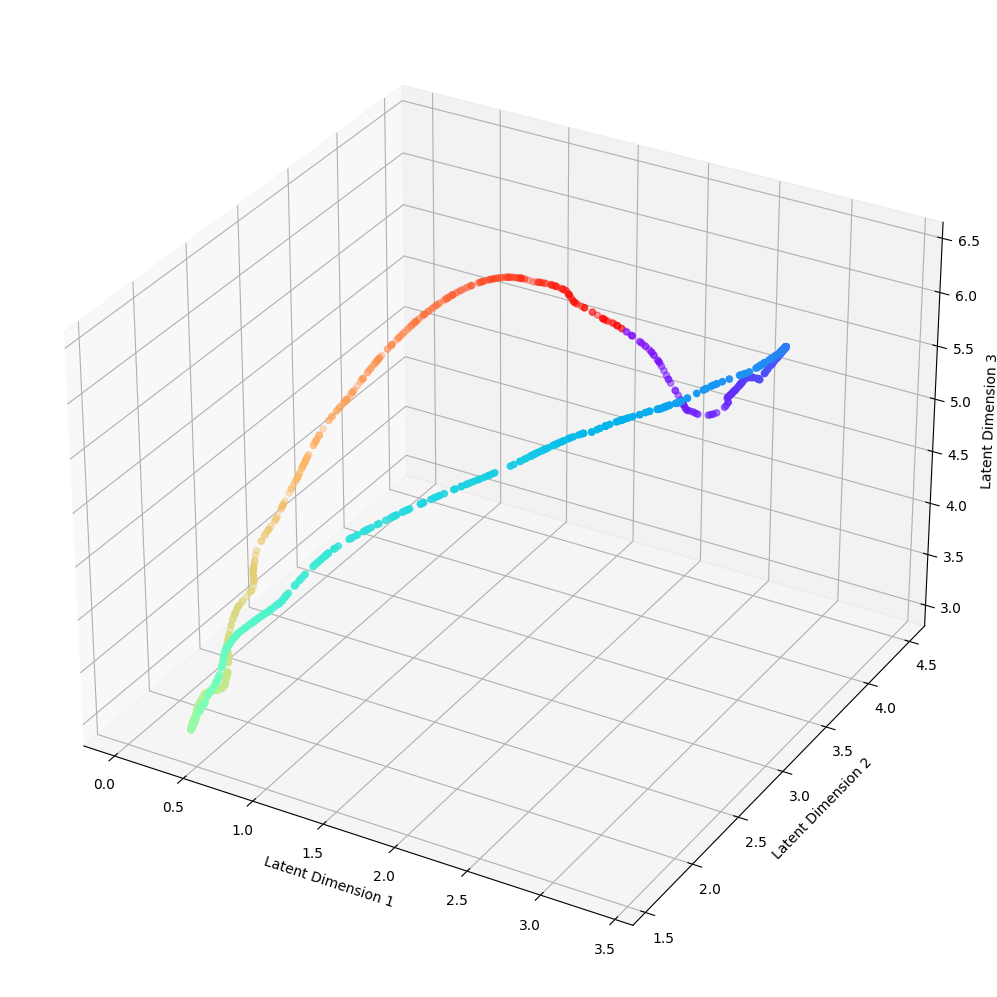

In [ ]:

fig = plt.figure(figsize=(20, 20))

x1 = np.array([point[0] for point in latent_space_data_p1])
y1 = np.array([point[1] for point in latent_space_data_p1])
z1 = np.array([point[2] for point in latent_space_data_p1])

ax1 = fig.add_subplot(221, projection='3d')


ax1.scatter(x1, y1, z1, color = colors1)


ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 2')
ax1.set_zlabel('Latent Dimension 3')

plt.tight_layout()
plt.show()


Text(0.5, 0, 'Phase')

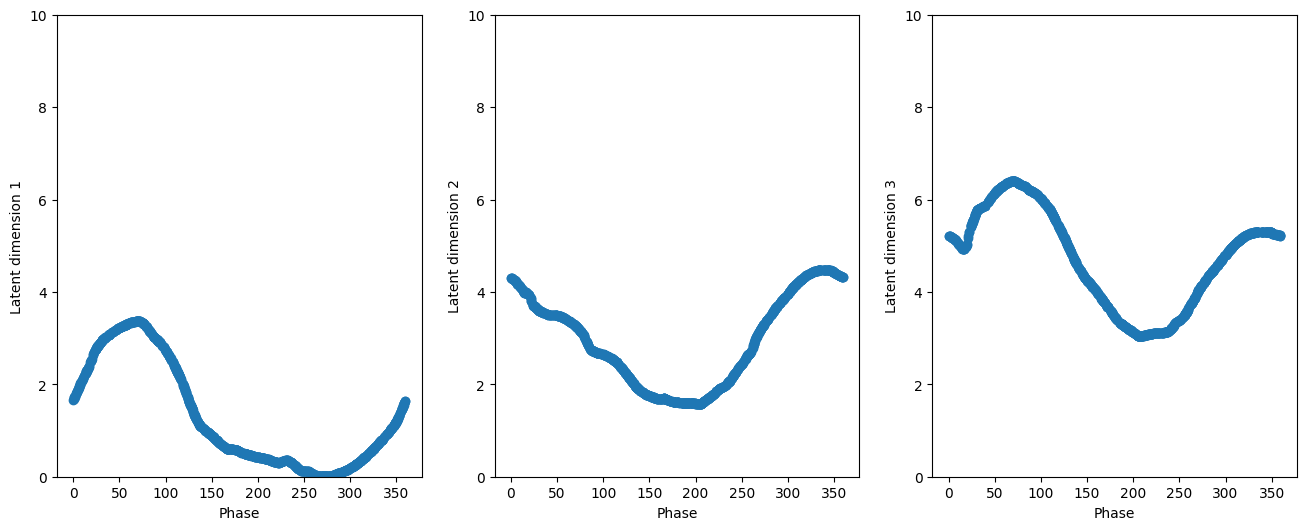

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].scatter(phase1p, latent_space_data_p1[:,0])
axs[1].scatter(phase1p, latent_space_data_p1[:,1])
axs[2].scatter(phase1p, latent_space_data_p1[:,2])

axs[0].set_ylim(0,10)
axs[1].set_ylim(0,10)
axs[2].set_ylim(0,10)

axs[0].set_ylabel('Latent dimension 1')
axs[1].set_ylabel('Latent dimension 2')
axs[2].set_ylabel('Latent dimension 3')


axs[0].set_xlabel('Phase')
axs[1].set_xlabel('Phase')
axs[2].set_xlabel('Phase')


AMPLITUDE

In [ ]:
m = 1000

ya1 = np.array([[0 for _ in range(100)] for _ in range(m)]).astype("float32") #2000 files 100 columnes
period1 = [0 for _ in range(m)]
amplitud1a = [0 for _ in range(m)]
phase1 = [0 for _ in range(m)]
data_a1 = np.empty(shape=(m, 100), dtype='object')


In [ ]:
for i in range(m):
  amplitud1a[i] = np.random.uniform(1,10)
  period1[i] = 25
  phase1[i] = 50

amplitud1a = sorted(amplitud1a)

for i in range(m):
  for j in range(100):
    ya1[i,j] = amplitud1a[i] * np.sin(2. * np.pi * (t[j] / period1[i] + phase1[i] / 360.))

for i in range(m):
  for j in range(100):
    data_a1[i][j]=ya1[i,j]

data_a1 = np.array(data_a1).astype('float32')
data_a1 = data_a1[~np.isnan(data_a1)]
data_a1 = data_a1.reshape((len(data_a1)//100,100*1)).astype('float32')

data_a1 = (data_a1-np.min(data_a1))/(np.max(data_a1)-np.min(data_a1))
data_a1 = data_a1.reshape((-1, 1, 100))
data_a1 = tf.stack(data_a1)





In [ ]:
latent_space_data_a1 = np.array(autoencoder.encoder(data_a1))
latent_space_data_a1 = latent_space_data_a1.reshape(m,3)


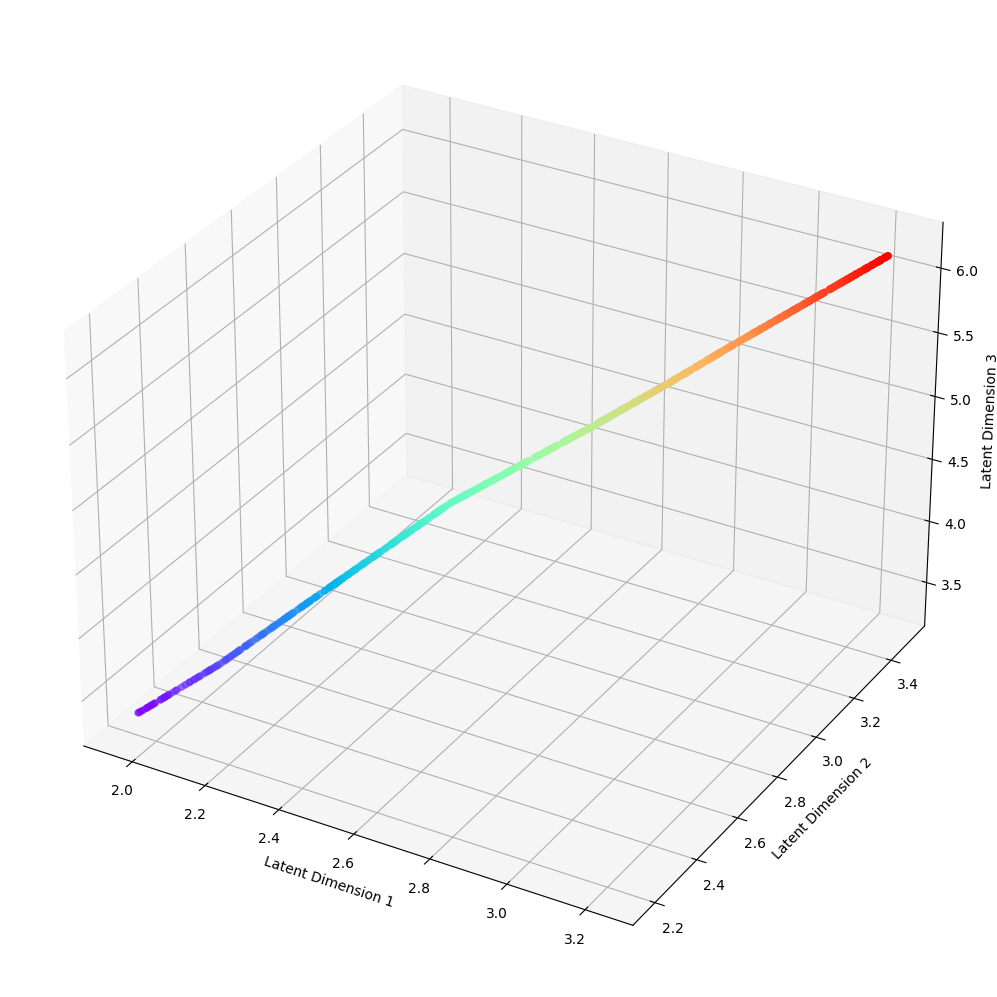

In [ ]:
jet=plt.get_cmap('rainbow')
colors1=jet(np.linspace(0,1,m))

fig = plt.figure(figsize=(20, 20))

# Extracting x, y, and z coordinates from the latent space data
x1 = np.array([point[0] for point in latent_space_data_a1])
y1 = np.array([point[1] for point in latent_space_data_a1])
z1 = np.array([point[2] for point in latent_space_data_a1])

# Add subplots with 3D projections
ax1 = fig.add_subplot(221, projection='3d')


# Plot data on each subplot
ax1.scatter(x1, y1, z1, color = colors1)


# Set labels and title
ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 2')
ax1.set_zlabel('Latent Dimension 3')

# Adjust layout
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Amplitude')

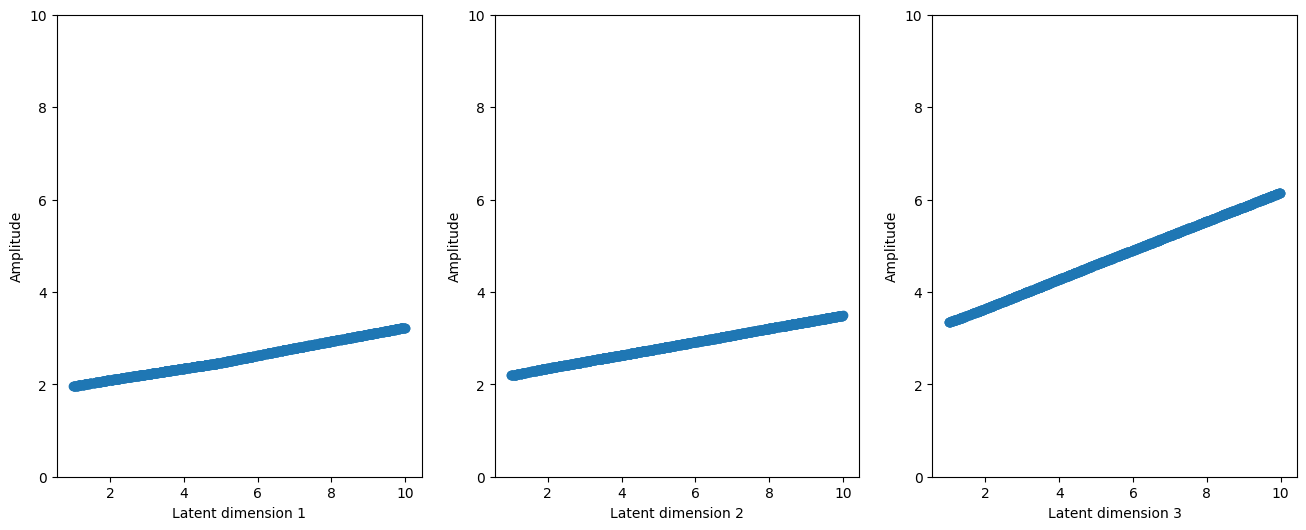

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[ 0].scatter(amplitud1a, latent_space_data_a1[:,0])
axs[ 1].scatter(amplitud1a, latent_space_data_a1[:,1])
axs[ 2].scatter(amplitud1a, latent_space_data_a1[:,2])

axs[0].set_ylim(0,10)
axs[1].set_ylim(0,10)
axs[2].set_ylim(0,10)

axs[0].set_xlabel('Latent dimension 1')
axs[1].set_xlabel('Latent dimension 2')
axs[2].set_xlabel('Latent dimension 3')


axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Amplitude')
axs[2].set_ylabel('Amplitude')

PERIOD

In [ ]:
m = 1000

ype1 = np.array([[0 for _ in range(100)] for _ in range(m)]).astype("float32") #2000 files 100 columnes
period1pe = [0 for _ in range(m)]
amplitud1 = [0 for _ in range(m)]
phase1 = [0 for _ in range(m)]
data_pe1 = np.empty(shape=(m, 100), dtype='object')



In [ ]:
for i in range(m):
  amplitud1[i] = 5
  period1pe[i] = np.random.uniform(25,35)
  phase1[i] = 50

period1pe = sorted(period1pe)
for i in range(m):
  for j in range(100):
    ype1[i,j] = amplitud1[i] * np.sin(2. * np.pi * (t[j] / period1pe[i] + phase1[i] / 360.))

for i in range(m):
  for j in range(100):
    data_pe1[i][j]=ype1[i,j]

data_pe1 = np.array(data_pe1).astype('float32')
data_pe1 = data_pe1[~np.isnan(data_pe1)]
data_pe1 = data_pe1.reshape((len(data_pe1)//100,100*1)).astype('float32')

data_pe1 = (data_pe1-np.min(data_pe1))/(np.max(data_pe1)-np.min(data_pe1))
data_pe1 = data_pe1.reshape((-1, 1, 100))
data_pe1 = tf.stack(data_pe1)


In [ ]:
latent_space_data_pe1 = np.array(autoencoder.encoder(data_pe1))
latent_space_data_pe1 = latent_space_data_pe1.reshape(m,3)


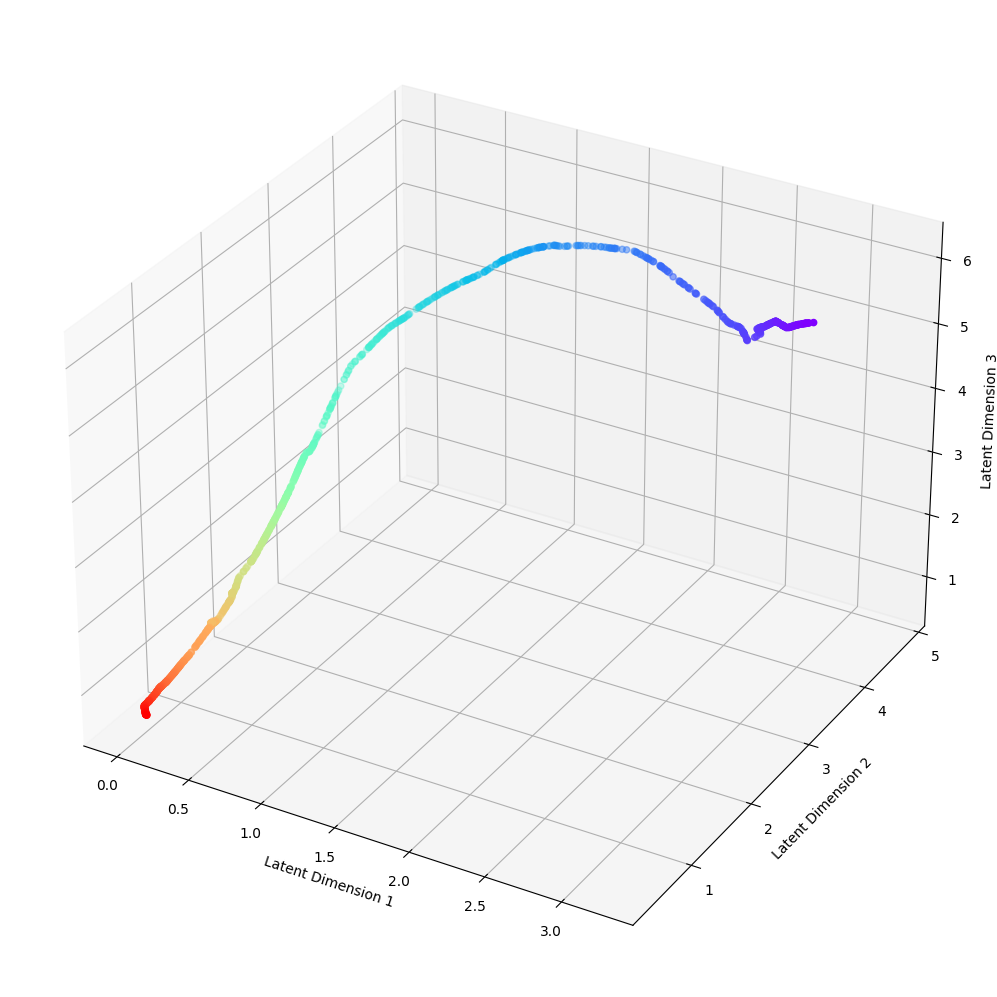

In [ ]:
jet=plt.get_cmap('rainbow')
colors1=jet(np.linspace(0,1,m))

fig = plt.figure(figsize=(20, 20))

# Extracting x, y, and z coordinates from the latent space data
x1 = np.array([point[0] for point in latent_space_data_pe1])
y1 = np.array([point[1] for point in latent_space_data_pe1])
z1 = np.array([point[2] for point in latent_space_data_pe1])

# Add subplots with 3D projections
ax1 = fig.add_subplot(221, projection='3d')


# Plot data on each subplot
ax1.scatter(x1, y1, z1, color = colors1)


# Set labels and title
ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 2')
ax1.set_zlabel('Latent Dimension 3')

# Adjust layout
plt.tight_layout()
plt.show()


Text(0.5, 0, 'Period')

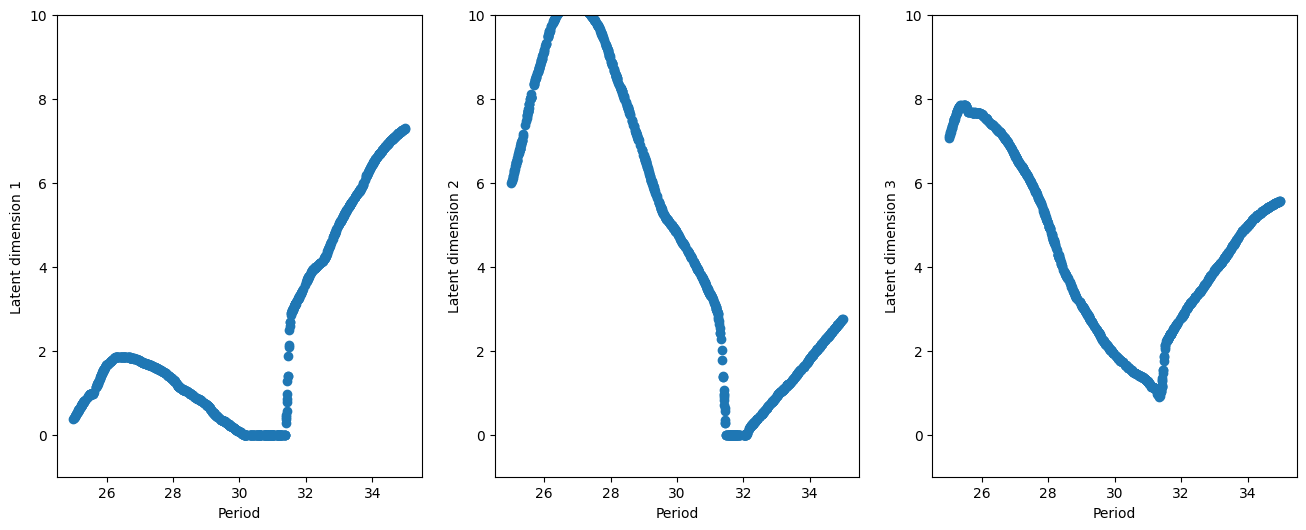

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[ 0].scatter(period1pe, latent_space_data_pe1[:,0])
axs[ 1].scatter(period1pe, latent_space_data_pe1[:,1])
axs[ 2].scatter(period1pe, latent_space_data_pe1[:,2])

axs[0].set_ylim(-1,10)
axs[1].set_ylim(-1,10)
axs[2].set_ylim(-1,10)

axs[0].set_ylabel('Latent dimension 1')
axs[1].set_ylabel('Latent dimension 2')
axs[2].set_ylabel('Latent dimension 3')


axs[0].set_xlabel('Period')
axs[1].set_xlabel('Period')
axs[2].set_xlabel('Period')